In [27]:
!pip install emoji
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install accelerate -U
!pip install fastText

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
import os
os._exit(00)

In [1]:
import emoji
import re
import googleapiclient.discovery
import torch
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from huggingface_hub import notebook_login

In [2]:
dev = ' '
huggy_log =' '
fast_text_model = fasttext.load_model('lid.176.ftz')
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = dev
youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [28]:
def clean_text(text):
    allchars = [str for str in text.decode('utf-8')]
    emoji_list = [c for c in allchars if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.decode('utf-8').split() if not
                           any(i in str for i in emoji_list)])
    clean_text = re.sub('http[s]?://\S+', '', clean_text)
    if fast_text_model.predict(clean_text, k=1)[0][0] == '__label__en':
      return clean_text
    return ''

In [4]:
def getcomments(video):
  request = youtube.commentThreads().list(
      part="snippet",
      videoId=video,
      maxResults=100
      )
  comments = []
  response = request.execute()
  for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      text = clean_text(comment['textOriginal'].lower().strip().encode('utf8'))
      if text != '':
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            text,
            comment['videoId'],
        ])
  while (1 == 1):
    try:
     nextPageToken = response['nextPageToken']
    except KeyError:
     break
    nextPageToken = response['nextPageToken']
    nextRequest = youtube.commentThreads().list(part="snippet", videoId=video,
                                                maxResults=100, pageToken=nextPageToken)
    response = nextRequest.execute()
    for item in response['items']:
      comment = item['snippet']['topLevelComment']['snippet']
      text = clean_text(comment['textOriginal'].lower().strip().encode('utf8'))
      if text != '':
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            text,
            comment['videoId'],
        ])

  df = pd.DataFrame(comments, columns=['author', 'updated_at', 'like_count',
                                        'text','video_id'])
  return df

In [5]:
df = getcomments('0VH9WCFV6XQ')
df

,author,updated_at,like_count,text,video_id
0,@HieuNguyen.contrai,2023-12-15T12:18:30Z,1,wowwwwwwwwwwwwwwwwwwww,0VH9WCFV6XQ
1,@troygoodwin5384,2023-12-15T07:59:51Z,1,nicolas cage done one similar,0VH9WCFV6XQ
2,@muhammadhumayl8323,2023-12-15T05:37:33Z,1,i just actually wanna watch this movie after w...,0VH9WCFV6XQ
3,@user-qz8zp1df1d,2023-12-15T01:34:58Z,0,nononoononononononononono beau me,0VH9WCFV6XQ
4,@ashleeorwin3442,2023-12-15T00:44:31Z,0,i absolutely loved the movie and the story lin...,0VH9WCFV6XQ
...,...,...,...,...,...
42155,@davidfaris6920,2023-06-27T14:59:57Z,0,first,0VH9WCFV6XQ
42156,@peanutbar015,2023-06-27T14:59:56Z,0,omg yasss,0VH9WCFV6XQ
42157,@ermset638,2023-06-27T14:59:56Z,0,yessss!!!!,0VH9WCFV6XQ
42158,@C-Lmemes,2023-06-27T14:59:52Z,1,omgggg,0VH9WCFV6XQ


In [29]:
df["text"]

0                                   wowwwwwwwwwwwwwwwwwwww
1                            nicolas cage done one similar
2        i just actually wanna watch this movie after w...
3                        nononoononononononononono beau me
4        i absolutely loved the movie and the story lin...
                               ...                        
42155                                                first
42156                                            omg yasss
42157                                           yessss!!!!
42158                                               omgggg
42159                                                  yay
Name: text, Length: 42160, dtype: object

In [31]:
df2 = getcomments('pBk4NYhWNMM')
df2

,author,updated_at,like_count,text,video_id
0,@spookygeek07,2023-12-15T14:28:48Z,1,i saw this movie and i absolutely adore it. i ...,pBk4NYhWNMM
1,@alexnclips6790,2023-12-15T14:00:05Z,0,how this got to a billion is beyond me,pBk4NYhWNMM
2,@kena1213,2023-12-15T07:54:47Z,0,kisses,pBk4NYhWNMM
3,@sev3n7z,2023-12-14T11:20:16Z,2,i'm not to sure what all the hurrah was about ...,pBk4NYhWNMM
4,@fredericoabiog3867,2023-12-14T08:02:41Z,1,i love this movie even i'm a boy,pBk4NYhWNMM
...,...,...,...,...,...
22318,@henrysheffield3998,2023-05-25T16:01:24Z,0,real,pBk4NYhWNMM
22319,@Blaze-zt5qm,2023-05-25T16:01:24Z,0,fiesta,pBk4NYhWNMM
22320,@mollypercocet1718,2023-05-25T16:01:13Z,0,first,pBk4NYhWNMM
22321,@Carnaaqe,2023-05-25T16:01:00Z,0,w,pBk4NYhWNMM


In [32]:
df3 = getcomments('uYPbbksJxIg')
df3

,author,updated_at,like_count,text,video_id
0,@XSakuraBellsX,2023-12-15T12:01:12Z,1,i could not hear a word in the actual movie. c...,uYPbbksJxIg
1,@gamasatrio1892,2023-12-15T09:27:28Z,0,oppenheimer,uYPbbksJxIg
2,@zillsburyy1,2023-12-15T06:39:31Z,1,i did not like this. it was like watching fear...,uYPbbksJxIg
3,@jasonapplebaum9871,2023-12-14T21:38:00Z,0,greatest movie of all time. this inspired me t...,uYPbbksJxIg
4,@user-gf8pg8zm9k,2023-12-14T08:10:43Z,2,this film is masterpiece..cillian deserve win ...,uYPbbksJxIg
...,...,...,...,...,...
20361,@xxxbrwxxxaleksanderhs1572,2023-05-08T07:03:05Z,1,shit,uYPbbksJxIg
20362,@alluarbind7248,2023-05-08T07:02:54Z,1,love u from nepal first comment,uYPbbksJxIg
20363,@LandonH117,2023-05-08T07:02:38Z,5,first edit: i just went to go see guardians of...,uYPbbksJxIg
20364,@elonmusknigachocolate,2023-05-08T07:02:28Z,8,this trailer alone is screaming over 8.5 imdb ...,uYPbbksJxIg


In [7]:
torch.cuda.is_available()

True

In [8]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(10000))])
test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(1000))])
print(train_dataset[0])
print(test_dataset[0])

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}
{'text': "<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, 

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions,
                                     references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [16]:
notebook_login(huggy_log)

In [17]:
repo_name = "finetuning-sentiment-model-10000-samples"

training_args = TrainingArguments(
    output_dir=repo_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.321800
1000,0.178500


TrainOutput(global_step=1250, training_loss=0.23207644958496093, metrics={'train_runtime': 1032.1053, 'train_samples_per_second': 19.378, 'train_steps_per_second': 1.211, 'total_flos': 2613747359731200.0, 'train_loss': 0.23207644958496093, 'epoch': 2.0})

In [19]:
trainer.evaluate()

<ipython-input-15-594229443b8d>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.26716411113739014,
 'eval_accuracy': 0.909,
 'eval_f1': 0.9079878665318504,
 'eval_runtime': 22.0107,
 'eval_samples_per_second': 45.433,
 'eval_steps_per_second': 2.862,
 'epoch': 2.0}

In [20]:
trainer.push_to_hub()

events.out.tfevents.1702657984.d8e09ef564f3.2309.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

'https://huggingface.co/pryshlyak/finetuning-sentiment-model-10000-samples/tree/main/'

In [22]:
sentiment_model = pipeline(model="pryshlyak/finetuning-sentiment-model-10000-samples")

sentiment_model(["I love it", "I hate it"])

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'LABEL_1', 'score': 0.9909390211105347},
 {'label': 'LABEL_0', 'score': 0.9790992140769958}]

In [23]:
def get_sentiment(df):
  list_comments = df["text"].astype(str).tolist()
  sentiments = []
  pos_score = 0
  neg_score = 0
  max_length = 256
  for i in range(0, len(list_comments)):
    sentiment = ''
    if len(list_comments[i]) > max_length:
      sentiment = sentiment_model(list_comments[i][:max_length])
    else:
      sentiment = sentiment_model(list_comments[i])
    if sentiment[0].get('label') == 'LABEL_0':
       sentiments.append('neg')
       if df['like_count'][i] > 0:
         neg_score += 1 * df['like_count'][i]
       else:
         neg_score += 1
    else:
       sentiments.append('pos')
       if df['like_count'][i] > 0:
         pos_score += 1 * df['like_count'][i]
       else:
         pos_score += 1
  return sentiments, pos_score, neg_score

In [24]:
sentiments, pos_score, neg_score = get_sentiment(df)
df['sentiments'] = sentiments
df

,author,updated_at,like_count,text,video_id,sentiments
0,@HieuNguyen.contrai,2023-12-15T12:18:30Z,1,wowwwwwwwwwwwwwwwwwwww,0VH9WCFV6XQ,pos
1,@troygoodwin5384,2023-12-15T07:59:51Z,1,nicolas cage done one similar,0VH9WCFV6XQ,pos
2,@muhammadhumayl8323,2023-12-15T05:37:33Z,1,i just actually wanna watch this movie after w...,0VH9WCFV6XQ,pos
3,@user-qz8zp1df1d,2023-12-15T01:34:58Z,0,nononoononononononononono beau me,0VH9WCFV6XQ,pos
4,@ashleeorwin3442,2023-12-15T00:44:31Z,0,i absolutely loved the movie and the story lin...,0VH9WCFV6XQ,pos
...,...,...,...,...,...,...
42155,@davidfaris6920,2023-06-27T14:59:57Z,0,first,0VH9WCFV6XQ,pos
42156,@peanutbar015,2023-06-27T14:59:56Z,0,omg yasss,0VH9WCFV6XQ,pos
42157,@ermset638,2023-06-27T14:59:56Z,0,yessss!!!!,0VH9WCFV6XQ,pos
42158,@C-Lmemes,2023-06-27T14:59:52Z,1,omgggg,0VH9WCFV6XQ,neg


In [25]:
df.to_csv('fnf_movie_comments_bert.csv', encoding='utf-8', index=False)

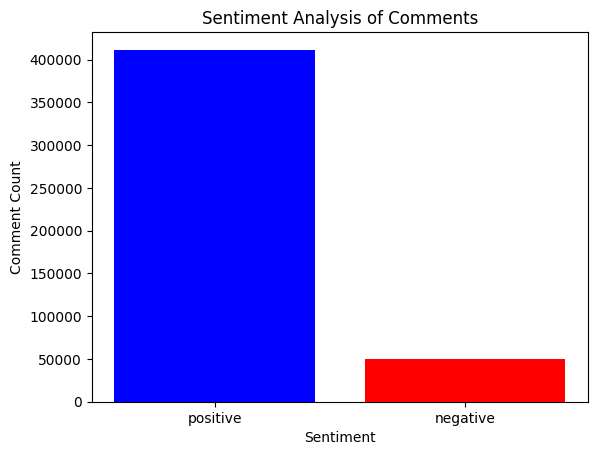

In [30]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [38]:
sentiments, pos_score, neg_score = get_sentiment(df2)

In [39]:
df2['sentiments'] = sentiments
df2

,author,updated_at,like_count,text,video_id,sentiments
0,@spookygeek07,2023-12-15T14:28:48Z,1,i saw this movie and i absolutely adore it. i ...,pBk4NYhWNMM,pos
1,@alexnclips6790,2023-12-15T14:00:05Z,0,how this got to a billion is beyond me,pBk4NYhWNMM,pos
2,@kena1213,2023-12-15T07:54:47Z,0,kisses,pBk4NYhWNMM,pos
3,@sev3n7z,2023-12-14T11:20:16Z,2,i'm not to sure what all the hurrah was about ...,pBk4NYhWNMM,neg
4,@fredericoabiog3867,2023-12-14T08:02:41Z,1,i love this movie even i'm a boy,pBk4NYhWNMM,pos
...,...,...,...,...,...,...
22318,@henrysheffield3998,2023-05-25T16:01:24Z,0,real,pBk4NYhWNMM,pos
22319,@Blaze-zt5qm,2023-05-25T16:01:24Z,0,fiesta,pBk4NYhWNMM,pos
22320,@mollypercocet1718,2023-05-25T16:01:13Z,0,first,pBk4NYhWNMM,pos
22321,@Carnaaqe,2023-05-25T16:01:00Z,0,w,pBk4NYhWNMM,neg


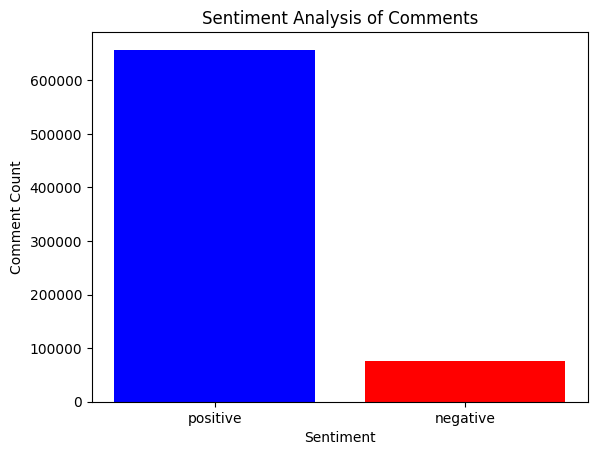

In [40]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [35]:
df2.to_csv('barbie_movie_comments_bert.csv', encoding='utf-8', index=False)

In [42]:
print(pos_score)
print(neg_score)

656905
75316


In [43]:
sentiments, pos_score, neg_score = get_sentiment(df3)

In [44]:
df3['sentiments'] = sentiments
df3

,author,updated_at,like_count,text,video_id,sentiments
0,@XSakuraBellsX,2023-12-15T12:01:12Z,1,i could not hear a word in the actual movie. c...,uYPbbksJxIg,neg
1,@gamasatrio1892,2023-12-15T09:27:28Z,0,oppenheimer,uYPbbksJxIg,pos
2,@zillsburyy1,2023-12-15T06:39:31Z,1,i did not like this. it was like watching fear...,uYPbbksJxIg,neg
3,@jasonapplebaum9871,2023-12-14T21:38:00Z,0,greatest movie of all time. this inspired me t...,uYPbbksJxIg,pos
4,@user-gf8pg8zm9k,2023-12-14T08:10:43Z,2,this film is masterpiece..cillian deserve win ...,uYPbbksJxIg,pos
...,...,...,...,...,...,...
20361,@xxxbrwxxxaleksanderhs1572,2023-05-08T07:03:05Z,1,shit,uYPbbksJxIg,neg
20362,@alluarbind7248,2023-05-08T07:02:54Z,1,love u from nepal first comment,uYPbbksJxIg,pos
20363,@LandonH117,2023-05-08T07:02:38Z,5,first edit: i just went to go see guardians of...,uYPbbksJxIg,pos
20364,@elonmusknigachocolate,2023-05-08T07:02:28Z,8,this trailer alone is screaming over 8.5 imdb ...,uYPbbksJxIg,pos


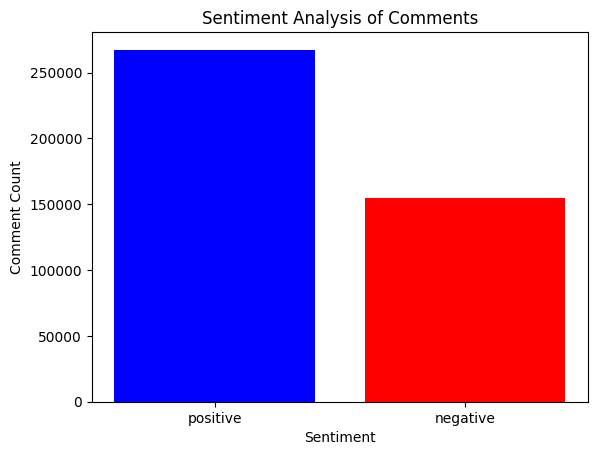

In [45]:
plt.bar(['positive', 'negative'], [pos_score, neg_score], color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Comment Count')
plt.title('Sentiment Analysis of Comments')
plt.show()

In [46]:
df3.to_csv('oppenheimer_movie_comments_bert.csv', encoding='utf-8', index=False)

In [47]:
print(pos_score)
print(neg_score)

267397
154595


In [51]:
count = 0
for i in range(0, len(df['text'])):
  if df['sentiments'][i] == 'neg':
    print(df['text'][i])
    count += 1
print(count)

Streaming output truncated to the last 5000 lines.
yep. watching in theaters.
please dont commit to the red orange eyes
cory in it ???
i’m pulling up in a suit to the theaters idc
holy fuck the fnaf jiggle
i’m about to cry
still waiting for cory to pop up here
who wants the phone guy to come back. it would be epic and we could hear the "hellooo?? helloooooooooo??!"
spring trap look stupid and bad
they got cory
it looks like gold fred or fred {a} is help her or {b} backstab her
been waiting 8 years
this is going to break the whole internet!
0:03 is this dude supposed to be michael afton?
damn we all grew up i guess
what will be the indicative rating of the film?
2:07 is springtrap gonna be in the movie!?
was that the bite of 87?!?!?!?!?
if the sequel isn’t sister location istg
ayo springtrap and cory kenshin pullin up???!! yoooooo
ooooohhhhhh im going crazy rn, i can't wait for ittttttttttt
wow, that looks awful, love the games, but this looks like ass
whoa now this is scary . :0
looks 

In [53]:
count = 0
for i in range(0, len(df2['text'])):
  if df2['sentiments'][i] == 'neg':
    print(df2['text'][i])
    count += 1
print(count)

Streaming output truncated to the last 5000 lines.
if i had a nickel for every time william farr played the antagonist of a movie about toys, i'd have two nickels, which isn't a lot, but it's weird that it happened twice.
if margot filmed herself reading a book for two hours, i would probably watch it...but i don't think i can set thru this act of stupidity!
gonna show up to this movie looking like i'm going to the met gala.
if there isn’t at least one sam and mickey reference in this movie i will be very sad
barbie girl playing in the end credits of the trailer is unexpected.
everyone at the party was just dancing and having a good time, until one person said "do you guys ever think about dying?"
scrolling down to see if anyone is curious if movie ken will be anatomically acurate
why just why?
trevor donovan looks more like a ken then ryan. just saying
imagine if netflix produced this, there would be a black barbie and kent xd
they should've casted lizzo!!!!
i can't believe i might ac

In [54]:
count = 0
for i in range(0, len(df3['text'])):
  if df3['sentiments'][i] == 'neg':
    print(df3['text'][i])
    count += 1
print(count)

Streaming output truncated to the last 5000 lines.
boring
jack quaid looks enough like feynman in this trailer that it was a bit freaky.
the team of scientists sent from britain wasn't screened properly and contained at least two soviet spies so the whole building a town in the middle of nowhere and keeping everyone there was largely a waste of time.
load of garbage propped up on a mountain of soot, just like what the bomb leaves behind
so thomas focking shelby is making bombs now eh
wait christopher nolan... is he gonna get an actual n u k e
2:47 damn!!! what an actor
without atomic nuclear bomb power that could end the world, we will probably having ww5 at the moment.
i'm gonna cream my pants over this!!!!
whenever i watch the trailer of an upcoming christopher nolan movie le my brain. - time to upgrade broda.
so much nuke propaganda like oh shit we had to totoally drop two of them on japan to end the war :p!!!! can't wait to see this anyway!
when you understand the science behind wh